In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pygmo as pg
import torch
import botorch
from botorch.utils.sampling import draw_sobol_samples
from botorch.utils.multi_objective.box_decompositions.dominated import (
    DominatedPartitioning,
)
from botorch.test_functions.multi_objective import BraninCurrin, DTLZ1, DTLZ2

In [2]:
def generate_initial_data(problem, n=6):
    X_obs = torch.empty(0, problem.bounds.shape[-1])
    y_obs = torch.empty(0, problem.bounds.shape[-1])
    while len(X_obs) < n:
        x = draw_sobol_samples(bounds=problem.bounds, n=1, q=1).squeeze(1)
        y = problem(x)
        if (y < problem.ref_point).all(dim=-1).item():
            X_obs = torch.concat([X_obs, x], dim=0)
            y_obs = torch.concat([y_obs, y], dim=0)

    return X_obs, y_obs

## Hypervolume contribution

- Use mono-surrogate model for multi-objective using scalarization
- Pareto hypervolume contribution (PHC) as scalarizer, uses the hypervoume contribution of a solution to its Pareto shell.

**Pareto hypervolume contribution** ( *PHC* ): directly use the hypervolume contribution of each solution.
> Let $ \upsilon(\mathbf{x}, \mathcal{P}^{\lambda}) $ be a function that calculates the hypervolume contribution of a solution $ \mathbf{x} $ to the Pareto shell $ \mathcal{P}^{\lambda}$ it resides int (**Improvement from each solution**):
> $$ \upsilon(\mathbf{x}, \mathcal{P}^{\lambda}) = H(\mathcal{P}^{\lambda}, \mathbf{r}) - H(\mathcal{P}^{\lambda} \setminus \{x\}, \mathbf{r} )\,. $$
> *PHC* of a solution is calculated by taking its hypervolume contribution and adding the largest contribution from each subsequent shells:
> $$ g_{\text{PHC}} = \upsilon(\mathbf{x}, \mathcal{P}^{\lambda}) + \sum^{N}_{i=\lambda+1} \max\{ \upsilon(\mathbf{x'}, \mathcal{P}^{i}) \mid \mathbf{x'} \in \mathcal{P}^i \}\,, $$
> where $ N $ is the total number of Pareto shells.

**MBORE**: scalarize the observed solutions and separate them into two classes via a threshold.
In essence, it used *BORE* to classify scalarized function values. They used their proposed *PHC* as the scalarization function.

**Question**:

- Why adding the largest contribution of each subsequent shell? What's the intuition?
  - If only calculate the improvement, then even solutions that are worst than the current Pareto set $\mathcal{P}^1$ might have larger scalarized values compared to solutions with only small improvement but better than $\mathcal{P}^1$.
  - The sum of maximums from previous Pareto shell act as a bias to ensure monotonicity.
- HPC is an alternative scalarization function for HypI, but why is it so much better than HypI with MBORE?
- Why just Hypervolume improvement not Expected HypI?

---

In [3]:
problem = BraninCurrin()
X_obs, y_obs = generate_initial_data(problem, n=20)

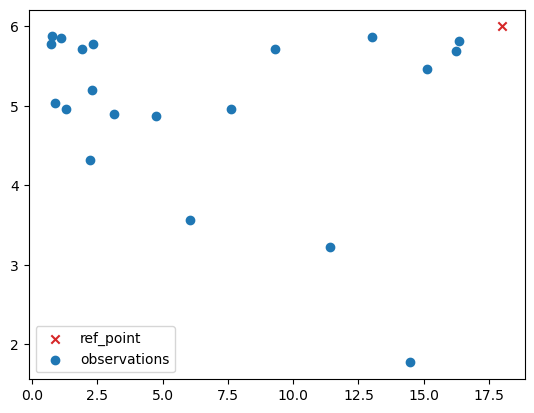

In [4]:
plt.scatter(*problem.ref_point, marker='x', color='tab:red', label="ref_point");
plt.scatter(*y_obs.t(),  color='tab:blue', label="observations")
plt.legend();

## Pareto shell

In [5]:
y = y_obs.numpy()
ndf, _, _, _ = pg.fast_non_dominated_sorting(y)   

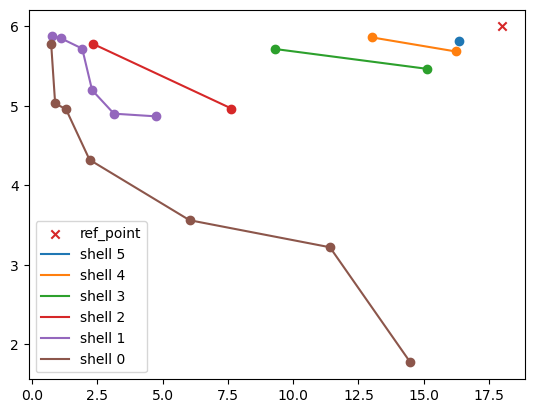

In [6]:
plt.scatter(*problem.ref_point, marker='x', color='tab:red', label="ref_point");
for shell_idx in range(len(ndf) - 1, -1, -1):
    shell = ndf[shell_idx]
    plt.scatter(*y[shell].T)
    sort_idx = np.argsort(y[shell][:, 0])
    plt.plot(*y[shell][sort_idx].T, label=f"shell {shell_idx}")
    plt.legend();

In [25]:
# hypervolume contribution
hvc = np.zeros((y.shape[0],))
ref_point = problem.ref_point.numpy()

In [26]:
for shell_idx in range(len(ndf) - 1, -1, -1):
    shell = ndf[shell_idx]
    print(f"initial hypervolume contribution for shell {shell_idx}:\n{hvc}")

    hv_class = pg.hypervolume(y[shell])

    # first calculate the exclusive hypervolume for each shell
    # (in reverse order) and add it to the current hypervolume value
    hvc[shell] += hv_class.contributions(ref_point)
    print(f"hypervolume contribution:\n{hvc}")

    # then, if not dealing with the last shell, add the maximum
    # of this shell's contributions (plus previous added contributions)
    if shell_idx > 0:
        hvc[ndf[shell_idx - 1]] += np.max(hvc[shell])
    print(f"add the maximum of the last shell to next shell:\n{hvc}\n\n")

initial hypervolume contribution for shell 5:
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
hypervolume contribution:
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.28927791 0.         0.         0.
 0.         0.        ]
add the maximum of the last shell to next shell:
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.28927791
 0.         0.         0.28927791 0.         0.         0.28927791
 0.         0.        ]


initial hypervolume contribution for shell 4:
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.28927791
 0.         0.         0.28927791 0.         0.         0.28927791
 0.         0.        ]
hypervolume contribution:
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  